In [1]:
import numpy as np, pandas as pd
import json

import matplotlib.pyplot as plt
plt.style.use('seaborn')

data needed:

1. energy levels and multiplicity data
2. line data (incl. wavelength, levels, transition rate)
3. element data such as atomic mass and ionization energy

In [4]:
# load databases

# a place to store the data
class SpectroscopicDatabase:

    __slots__ = 'lines', 'levels', 'info'

    def __init__(self) -> None:

        # specatral lines
        self.lines = pd.read_csv('./pylibs/data/lines.csv', 
                                 names = ['Element', 'SpecNum','Wavelen' ,'Aki', 'Acc', 'Ei', 'Ek', 'gi', 'gk', 'Type'],
                                 delimiter = ',', 
                                 comment = '#', 
                                 skipinitialspace = True, 
                                 na_values = ' ')

        # energy levels
        self.levels = pd.read_csv('./pylibs/data/levels.csv', 
                                  names = ['Element', 'SpecNum', 'g', 'Level', 'Unceratinity'],
                                  delimiter = ',', 
                                  comment = '#', 
                                  skipinitialspace = True, 
                                  na_values = ' ')

        # other info, incl. ionization energy
        self.info = json.load( open('./pylibs/data/info.json', 'r') )

specDB = SpectroscopicDatabase()

a plasma is specified by the plasma temperature $T_e$ in $\rm eV$, electron density $N_e$ in $\rm cm^{-3}$ and 
weight fraction of its component elements. in the plasma, each element $X$ exist in atleast its first two 
ionization states, neutral ($X_I$) and singly ionized ($X_{II}$).

In [95]:
# spectrum generator object: blue print
class SpectrumGenerator:

    __slots__ = 'Te', 'Ne', 'elementData', 'specData', 'lines'

    def __init__(self, weights, Te, Ne, db = specDB):
        
        # check if the all weights add up to 1, and data is available
        total = 0.0
        for sym, weight in weights.items():

            # data for this element should be available
            if sym not in db.info.keys():
                raise KeyError(f'No data available for element `{sym}`')

            # weight must be poistive
            if weight < 0:
                raise ValueError('Weight of an element cannnot be negative') 
            total += weight

        # check if total weight is 1
        if abs(total - 1.) > 1.e-08:
            raise ValueError('Total weight must be 1')

        # electron temperature (Te) and density (Ne)
        assert Te > 0. and Ne > 0. 
        self.Te, self.Ne = Te, Ne

        # element data: a table storing the element-wise data such as the mass, 
        # weigth and the number fraction 
        etab = pd.DataFrame([[sym,                  # element symbol
                              db.info[sym]['Z'],    # atomic number
                              db.info[sym]['Mass'], # atomic mass in u 
                              weight]               # weight
                              for sym, weight in weights.items()], 
                            columns=['Element', 'AtomicNum', 'Mass', 'Weight']
                        ).set_index('Element')
        etab.index.names = [None]
        self.elementData = etab

        # species data: a table storing the species-wise data such as ionization 
        # energy, partition function, number fraction... 

        # partition function
        def calculate_pf(sym, i):
            
            lvdata = db.levels.query(f"(Element=='{sym}') & (SpecNum=={i})").dropna() # energy levels of this species
            
            pf = np.sum( lvdata['g'] * np.exp(-lvdata['Level'] / Te) )
            return pf

        stab = pd.DataFrame([['-'.join([sym, 'I'*i]), # species id: eg. Cu-I
                              sym,                    # element symbol
                              i,                      # species number 
                              db.info[sym]['IonizationEnergy'][i-1], # ion energy
                              calculate_pf(sym, i)]   # partition function 
                              for sym in self.elementData.index for i in [1, 2]], 
                            columns = ['SpecID', 'Element', 'SpecNum', 'IonizationEnergy', 'PartitionFunction']
                        ).set_index('SpecID')
        stab.index.names = [None]
        self.specData = stab

        # lines for this combination
        self.lines = db.lines.query("Element in @self.elementData.index")
        self.lines = self.lines.reset_index().drop(['Type', 'index'], axis=1)
        self.lines['Intensity'] = np.nan

        self.calculate_numbers() # calculate number fractions

        self.calculate_intensities() # calculate line intensities

    def calculate_numbers(self):
        ...

    def calculate_intensities(self):
        ...

    def get_spectrum(self, x, res = 1000, full_output = False):
        ...

weight to number fraction conversion: $ n = \frac{w / m}{ \sum w / m} $

assuming local thermal equilibruim, numbers of ionised species are given by saha-boltzmann equation

$$
    f_{i} = \frac{n_{i+1}}{n_{i}} = 6.009\times 10^{21} \frac{T_e^{3/2}}{n_e} \frac{U_{i+1}}{U_{i}} e^{-V_{i}/T_e}
$$

then $n_{1} = n/(1 + f_{1})$ and $n_{2} = f_{1} n_{1}$, where, $U(T_e)$ is the partition function for that species 
and $V_i$ is the ionization energy.

In [96]:
# calculate number fractions of elements and species
def calculate_numbers(self):
    
    # convert element weights to number fractions
    self.elementData.eval('Number = Weight / Mass', inplace = True)
    self.elementData['Number'] /= self.elementData['Number'].sum() # normalize

    # calculate species number fractions, assuming local thermal equilibrium
    const = 6.009e+21 * self.Te**1.5 / self.Ne
    pf    = self.specData['PartitionFunction'].values
    Ei    = self.specData['IonizationEnergy'].values
    frac  = const * (pf[1::2] / pf[::2]) * np.exp(-Ei[::2] / self.Te)
    
    num   = np.zeros_like(pf)
    num[::2]  = self.elementData['Number'].values / (1. + frac) # neutral
    num[1::2] = num[::2] * frac
    self.specData['Number'] = num

    return

# link this function to the class
SpectrumGenerator.calculate_numbers = calculate_numbers

for each line of a species, calculate the line intensity as 

$$
    I(\lambda_{0}) = \frac{1}{4\pi} n_k A_{ki} (E_k - E_i)
$$

where, $A_{ki}$ is the transition rate, $n_k = \frac{n}{U} g_k \exp(-E_k/T_e)$ is the population of the upper 
level of transition, $E_i$ and $E_k$ are the lower and upper energy levels and $\lambda_{0}$ is the wavelength.

In [120]:
# calculate line intensities using boltzmann equation
def calculate_intensities(self: SpectrumGenerator):

    j = self.lines['Element'] + '-' + self.lines['SpecNum'].map({1: 'I', 2: 'II'}) # species id for each line

    # calculate upper level population
    nk = ( self.specData['Number'].loc[j] / self.specData['PartitionFunction'].loc[j] ).values * self.lines['gk'] * np.exp(-self.lines['Ek'] / self.Te)

    # calculate intensity
    self.lines['Intensity'] = nk * self.lines['Aki'] * (self.lines['Ek']-self.lines['Ei']) / (4*np.pi)
    return

# link this function to the class
SpectrumGenerator.calculate_intensities = calculate_intensities

a gaussian shape is given to each line. if $R$ is the resolving power of the spectrometer, full width at half maximum 
of that line is $w = \lambda_0 / R$ and shape function is

$$
    I(\lambda) = I(\lambda_{0}) \exp \left[ -4 \ln(2) \left( \frac{\lambda - \lambda_0}{w} \right)^2 \right]
$$

add up all the shapes to make the final spectrum.

In [122]:
# gaussian profile for the line
def gaussian(x, center, width):

    u = (x - center) / width
    return np.exp( -4*np.log(2) * u**2 )

# sample the spectrum at given points
def get_spectrum(self, x, res = 1000, full_output = False):

    spec = pd.DataFrame({'Wavelen': x, })
    for s in self.specData.index:
        spec[s] = np.zeros_like(x) # intensity for each component spectrum

    # calculate spectrum intensity
    id = self.lines['Element'] + '-' + self.lines['SpecNum'].map({1: 'I', 2: 'II'}) # species id for each line
    for i in self.lines.index:
        x0 = self.lines.at[i,'Wavelen']
        y  = self.lines.at[i,'Intensity'] * gaussian(x, x0, x0 / res)

        spec[id[i]] += y
    
    spec['Sum'] = spec.drop('Wavelen', axis=1).sum(axis=1)

    if full_output:
        return spec
    return spec[['Wavelen', 'Sum']]

# link this function to the class
SpectrumGenerator.get_spectrum = get_spectrum

In [123]:
# test spectrum: 70% cu and 30% tin

sg = SpectrumGenerator({'Cu':0.7, 'Sn':0.3}, 1., 1e+17)

In [124]:
sg.elementData

,AtomicNum,Mass,Weight,Number
Cu,29,63.546,0.7,0.813369
Sn,50,118.690,0.3,0.186631


In [125]:
sg.specData

,Element,SpecNum,IonizationEnergy,PartitionFunction,Number
Cu-I,Cu,1,7.726380,5.333798,0.070653
Cu-II,Cu,2,20.292390,2.115692,0.742716
Sn-I,Sn,1,7.343918,9.707661,0.010030
Sn-II,Sn,2,14.633070,4.399794,0.176601


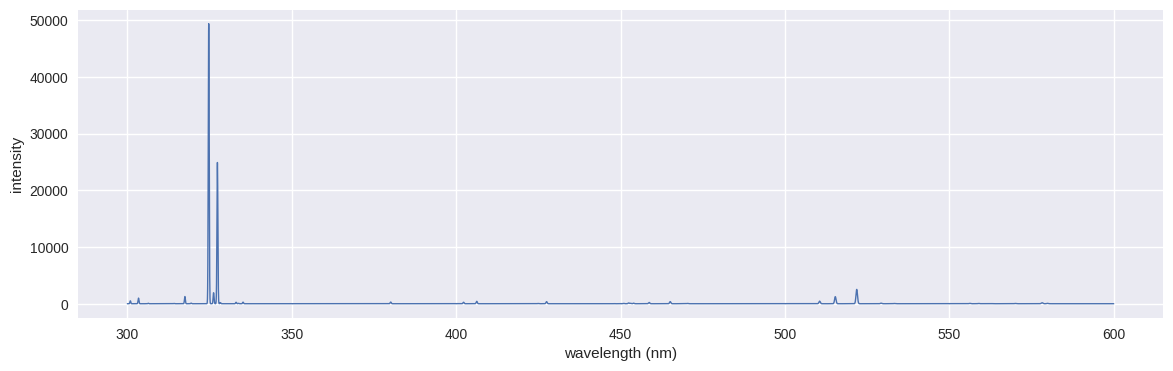

In [128]:
# spectrum with equall spaced sampling
x = np.linspace(300, 600, 10001)

spec = sg.get_spectrum(x, res = 1000)

fig, ax = plt.subplots(1, 1, figsize = [14, 4])
ax.plot(spec['Wavelen'], spec['Sum'], '-', lw = 1, )
ax.set(xlabel = 'wavelength (nm)', ylabel = 'intensity')
plt.show()

In [192]:
# adaptive sampling: regions with more lines gets more samples

def adaptive_sample(xleft, xright, x, res = 10): # NOTE: testing, not optimized

    x = np.unique(x) # get unique lines

    # sub-dividing the range so that a subdivision gets only 0 or 1 line
    c1 = [(xleft, xright, x[(xleft <= x) & (x < xright)])]
    while 1:
        c2   = []
        stop = True
        for xl, xr, _x in c1:

            # if the sub-division has 0 or 1 line only, no sub-division
            if len(_x) < 2:
                c2.append([xl, xr, _x])
                continue

            # otherwise, equally divide the range into 2
            stop = False
            xc   = 0.5 * (xl + xr)
            c2.append([xl, xc, _x[(xl < _x) & (_x <= xc)]])
            c2.append([xc, xr, _x[(xc < _x) & (_x < xr)]])
        
        c1 = c2 
        if stop:
            break

    # sample points in each sub-divisions and combine together
    return np.hstack([np.linspace(xl, xr, res) for xl, xr, _ in c1])

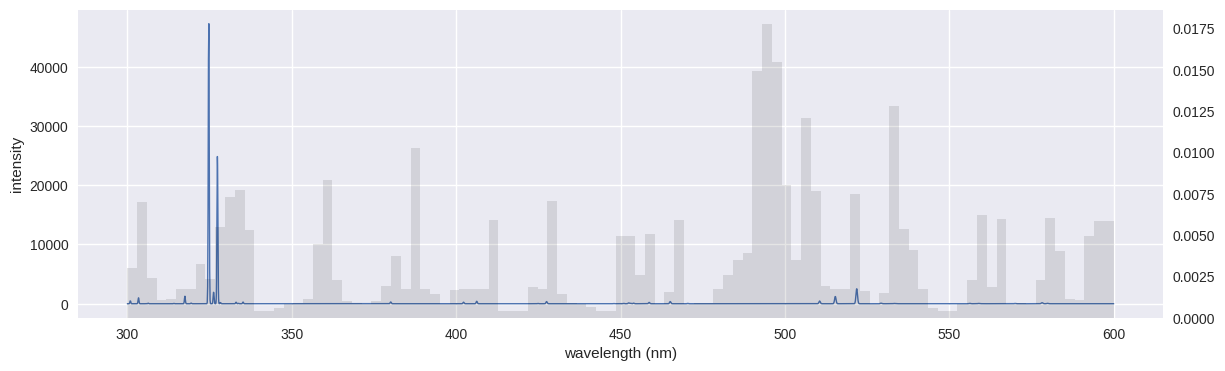

In [194]:
# spectrum with un-equal sampling
x = adaptive_sample(300, 600, x = sg.lines['Wavelen'].values, res = 20)

spec = sg.get_spectrum(x, res = 1000)

fig, ax = plt.subplots(1, 1, figsize = [14, 4])
ax.plot(spec['Wavelen'], spec['Sum'], '-', lw = 1, )
ax.set(xlabel = 'wavelength (nm)', ylabel = 'intensity')

# sampling density
ax2 = ax.twinx()
ax2.hist(x, bins = 101, range = [300, 600], density = True, lw = 1, color = 'black', alpha = 0.1)
ax2.grid(0)
plt.show()